In [1]:
from glob import glob
import os

from lzma import compress
from src import spec_from_path
from itertools import combinations
from functools import cache
from scipy.cluster import hierarchy
import plotly.graph_objects as go
import numpy as np

In [346]:
file_bytes = dict()
for fpath in glob(os.path.join("results/vega-lite/vega-lite/preproc", "*.*")):
    spec = spec_from_path(fpath)
    with open(fpath, "rb") as f:
        file_bytes[spec] = f.read()
specs = list(file_bytes.keys())

In [347]:
len(specs)

529

In [598]:
@cache
def C(*in_specs):
     return len(compress(b"".join(file_bytes[s] for s in sorted(in_specs))))

In [390]:
def make_nodes(P, order):
    nodes = dict()
    root = (0, 0)
    for xs, ys in zip(P["dcoord"], P["icoord"]):
        x_mid = (xs[1] + xs[2]) / 2
        y_mid = (ys[1] + ys[2]) / 2
        root = max(root, (x_mid, y_mid))
        for k, key in enumerate([(xs[1], ys[1]), (x_mid, y_mid), (xs[2], ys[2])]):
            nodes[key] = [[]]
            for i in [0, 3]:
                if (i == 0 and k != 2) or (i == 3 and k != 0):
                    nodes[key][0].append((xs[i], ys[i]))
                if xs[i] == 0:
                    leaf_id = order.index(P["ivl"][int((ys[i] - 5) / 10)])
                    nodes[(xs[i], ys[i])] = [[leaf_id], [leaf_id]]
    for n in nodes:
        append_members(nodes, n)
    return nodes, root

In [391]:
def append_members(nodes, node):
    if len(nodes[node]) == 2:
        return nodes[node][1]
    nodes[node].append([])
    for child in nodes[node][0]:
        if type(child) is int:
            nodes[node][1].append(child)
        else:
            nodes[node][1] += append_members(nodes, child)
    return nodes[node][1]

In [584]:
def dendro(Z, order, x_is_total_i=True):
    P = hierarchy.dendrogram(Z, labels=order, no_plot=True)
    nodes, root = make_nodes(P, order)
    x = []
    y = []
    hovertext = []
    label_x = []
    label_y = []
    label_text = []
    y_by_spec = dict()

    def append_point(x_val, y_val):
        y.append(y_val)
        x.append(x_val)
        cluster_members = nodes[(x_val, y_val)][1]
        node_spec = None
        #if len(cluster_members):
        #    cluster_medioid = medioid(cluster_members, dmat_sym)
        #    node_spec = order[cluster_medioid]
        hovertext.append(node_spec)


    for i, (icoord, dcoord) in enumerate(zip(P["icoord"], P["dcoord"])):
        for j, (y_val, x_val) in enumerate(zip(icoord, dcoord)):
            append_point(x_val, y_val)
            if x_val == 0:
                spec = P["ivl"][int((y_val - 5) / 10)]
                if x_is_total_i:
                    x_val = C(spec)
                    x[-1] = x_val
                if spec not in y_by_spec:
                    y_by_spec[spec] = y_val
                    label_x.append(x_val)
                    label_y.append(y_val)
                    label_text.append(spec)
        y.append(None)
        x.append(None)
        hovertext.append(None)

    append_point(root[0], root[1])


    fig = go.Figure()
    fig.add_scatter(x=x, y=y, line_width=1, hovertext=hovertext, hoverinfo="none", mode="lines+markers", marker_size=1)
    fig.add_scatter(
        x=np.array(label_x)[np.argsort(label_y)],
        y=np.array(label_y)[np.argsort(label_y)],
        text=np.array(label_text)[np.argsort(label_y)],
        mode="markers+text",
        textposition="middle right",
        hoverinfo="skip",
        marker=dict(cmin=0, symbol="square"),
    )
    fig.update_layout(height=800, showlegend=False, dragmode="pan", plot_bgcolor="white")
    fig.update_layout(uirevision="yes")
    fig.update_yaxes(visible=False)
    fig.update_xaxes(autorange="reversed")
    fig.add_vline(x=0, line_color="black")
    fig.show(config=dict(scrollZoom=True))

In [599]:
C(*specs), sum(C(s) for s in specs), sum(C(s) for s in specs)/C(*specs)

(27064, 178364, 6.590452261306533)

In [607]:
%%time
clusters = [[s] for s in specs]
remaining = clusters.copy()
linkage = []
while len(remaining) > 1:
    min_dist, c1, c2 = min((C(*(i+j)), i, j) for i, j in combinations(remaining, 2))
    linkage.append([float(clusters.index(c1)), float(clusters.index(c2)), float(min_dist), float(len(c1+c2))])
    clusters.append(c1+c2)
    remaining.remove(c1)
    remaining.remove(c2)
    remaining.append(c1+c2)


CPU times: user 5.5 s, sys: 10.4 ms, total: 5.51 s
Wall time: 5.51 s


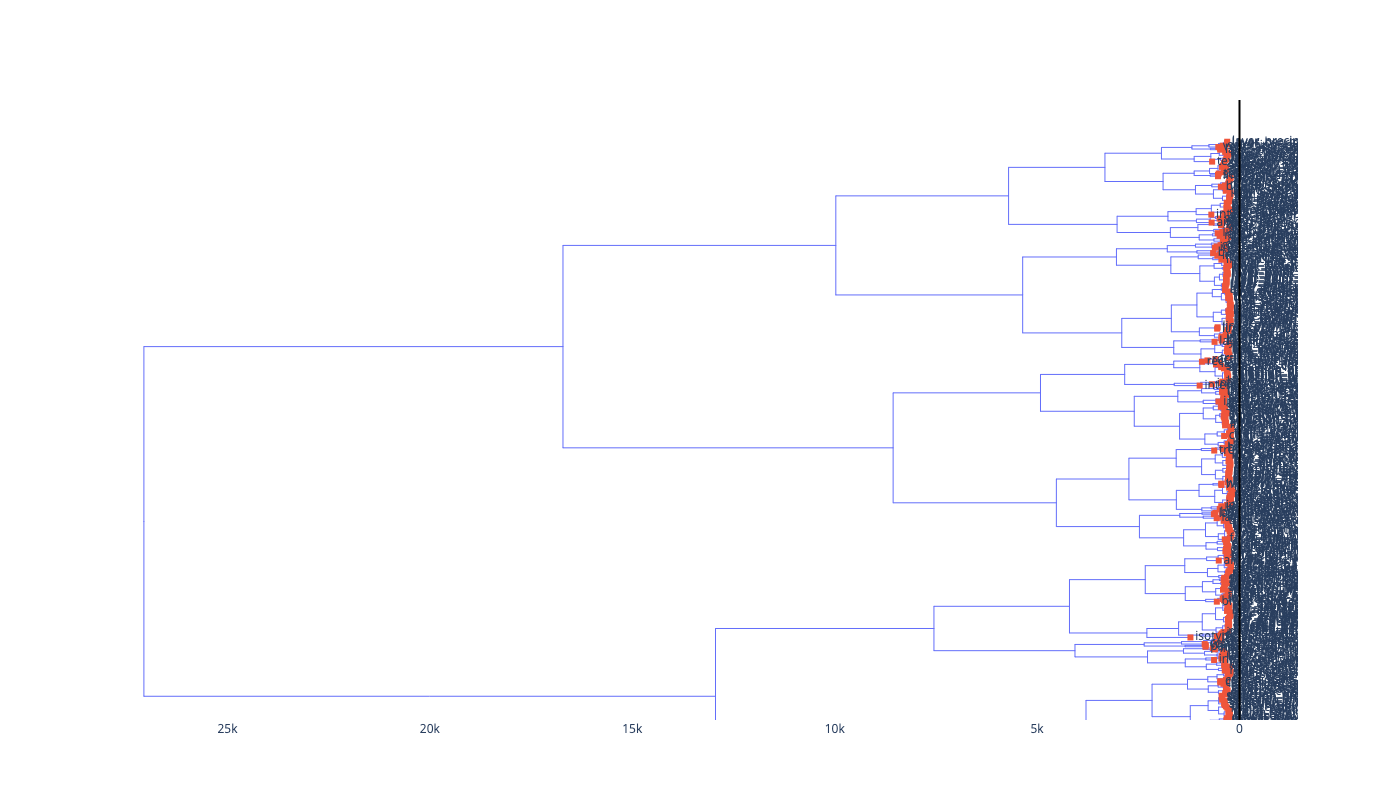

In [601]:
dendro(linkage, specs)

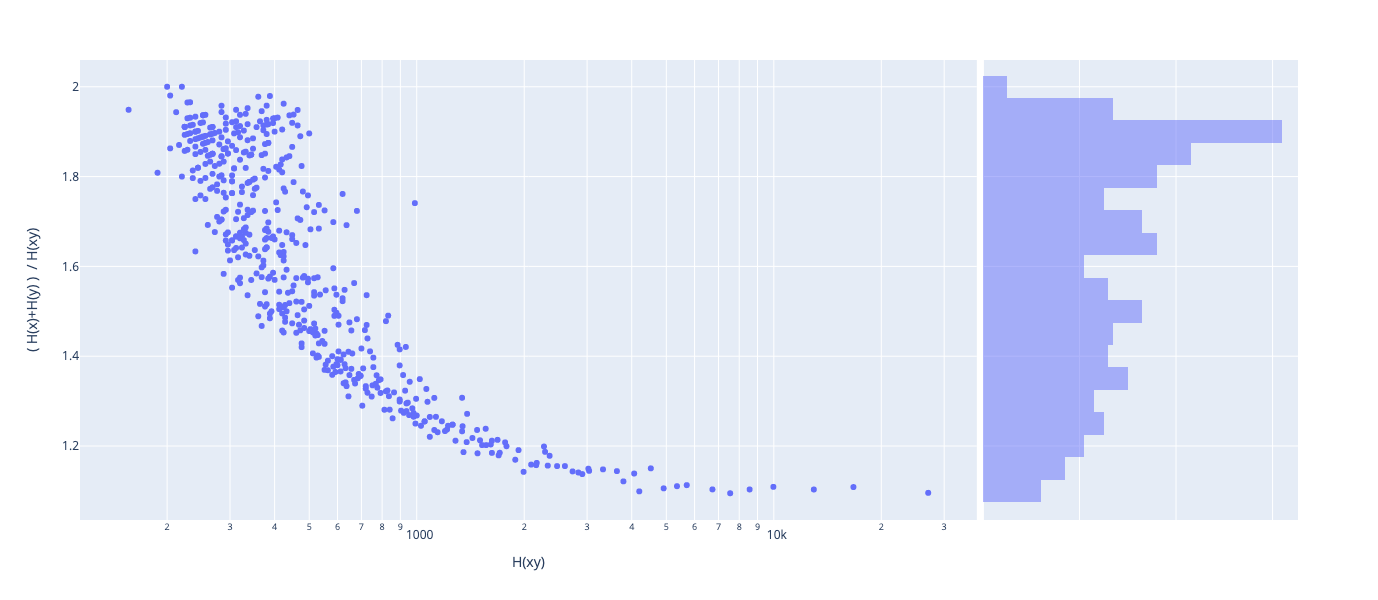

In [602]:
x = []
y = []
for i, (c1,c2,dist,n) in enumerate(linkage):
    y.append(( C(*clusters[int(c2)]) + C(*clusters[int(c1)]) ) / C(*(clusters[int(c1)] + clusters[int(c2)])) )
    x.append( C(*(clusters[int(c1)] + clusters[int(c2)])) )
import plotly.express as px
px.scatter(x=x, y=y, labels=dict(x="H(xy)", y="( H(x)+H(y) )  / H(xy) "), width=600, height=600, log_x=True, marginal_y="histogram")

In [525]:
clusters = [[s] for s in specs]
remaining = clusters.copy()
linkage = []
while len(remaining) > 0:
    if len(linkage) == 0:
        min_dist, c1, c2 = min((C(*(i+j)), i, j) for i, j in combinations(remaining, 2))
        remaining.remove(c1)
    else:
        min_dist, c1, c2 = min((C(*(clusters[-1]+i)), clusters[-1], i) for i in remaining)
    linkage.append([float(clusters.index(c1)), float(clusters.index(c2)), float(min_dist), float(len(c1+c2))])
    clusters.append(c1+c2)
    remaining.remove(c2)


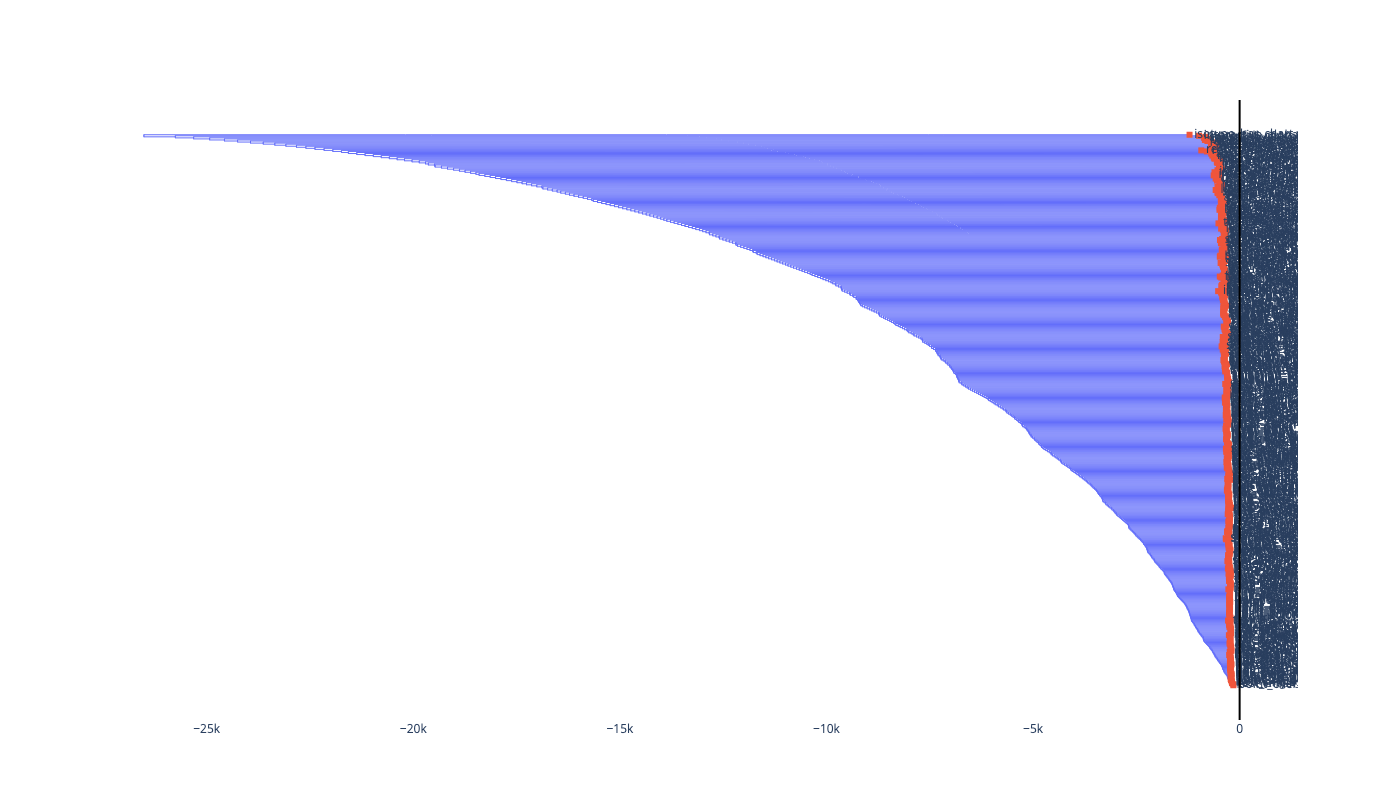

In [526]:
dendro(linkage, specs)

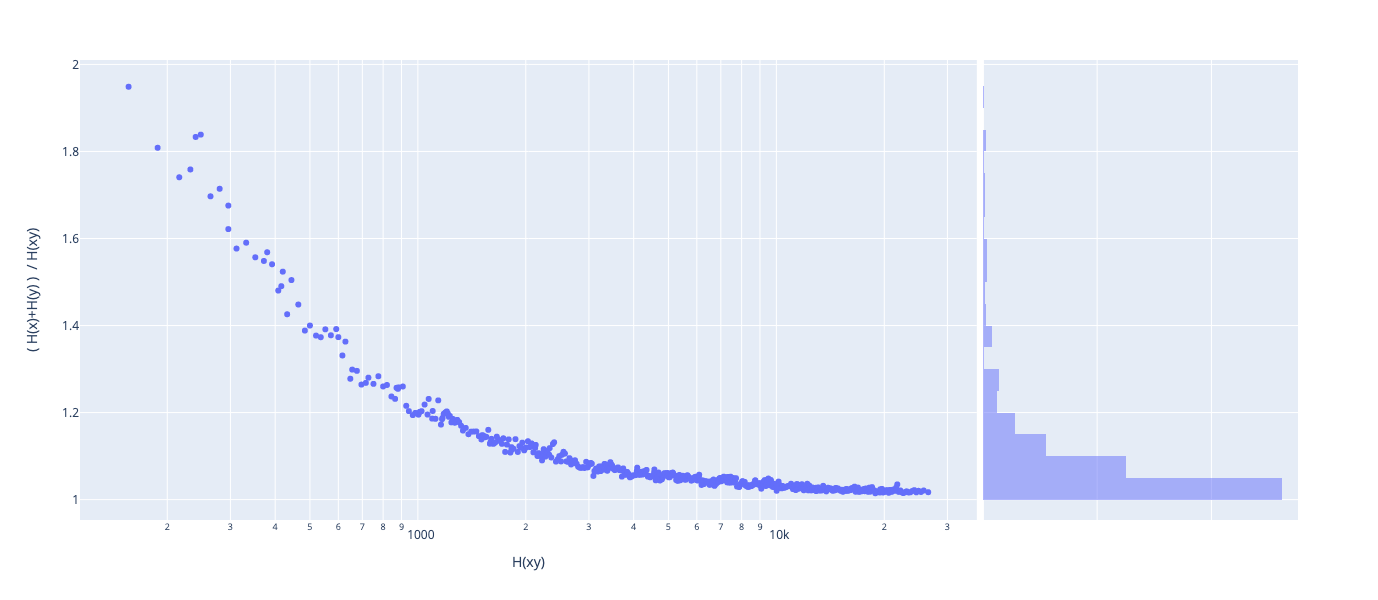

In [527]:
x = []
y = []
for i, (c1,c2,dist,n) in enumerate(linkage):
    y.append(( C(*clusters[int(c2)]) + C(*clusters[int(c1)]) ) / C(*(clusters[int(c1)] + clusters[int(c2)])) )
    x.append( C(*(clusters[int(c1)] + clusters[int(c2)])) )
import plotly.express as px
px.scatter(x=x, y=y, labels=dict(x="H(xy)", y="( H(x)+H(y) )  / H(xy) "), width=600, height=600, log_x=True, marginal_y="histogram")

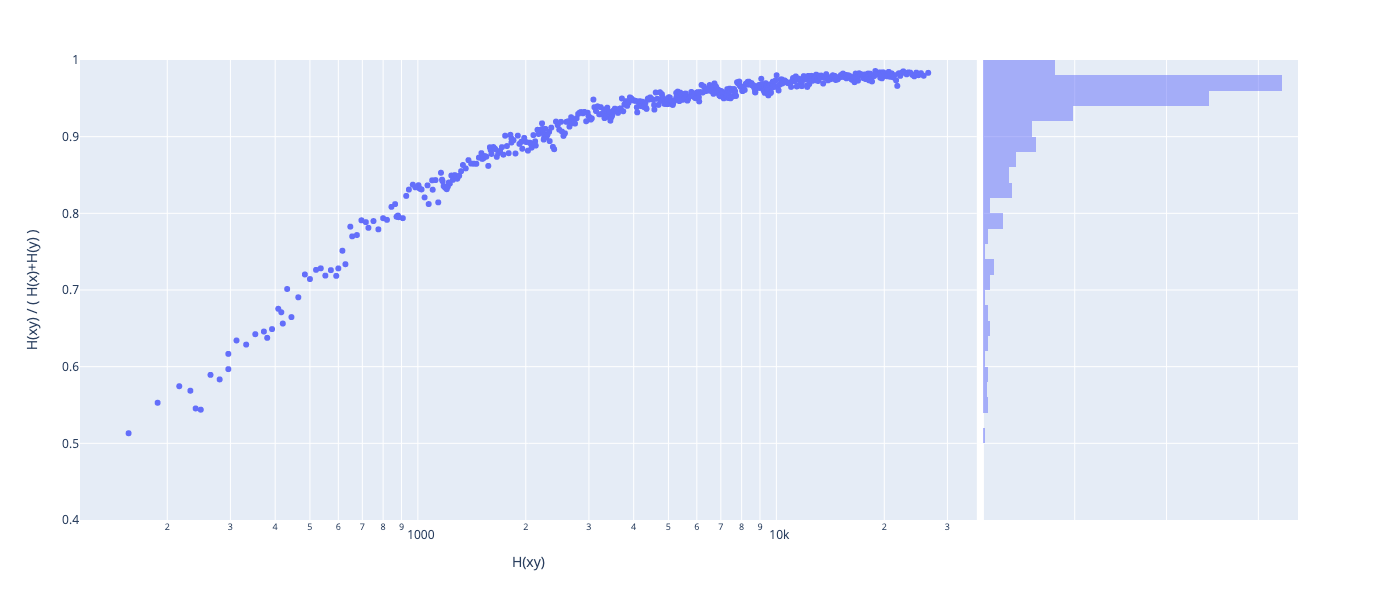

In [521]:
x = []
y = []
for i, (c1,c2,dist,n) in enumerate(linkage):
    y.append(C(*(clusters[int(c1)] + clusters[int(c2)]))/ ( C(*clusters[int(c2)]) + C(*clusters[int(c1)]) ))
    x.append( C(*(clusters[int(c1)] + clusters[int(c2)])) )
import plotly.express as px
px.scatter(x=x, y=y, labels=dict(x="H(xy)", y="H(xy) / ( H(x)+H(y) ) "), width=600, height=600, range_y=[0.4,1], log_x=True, marginal_y="histogram")

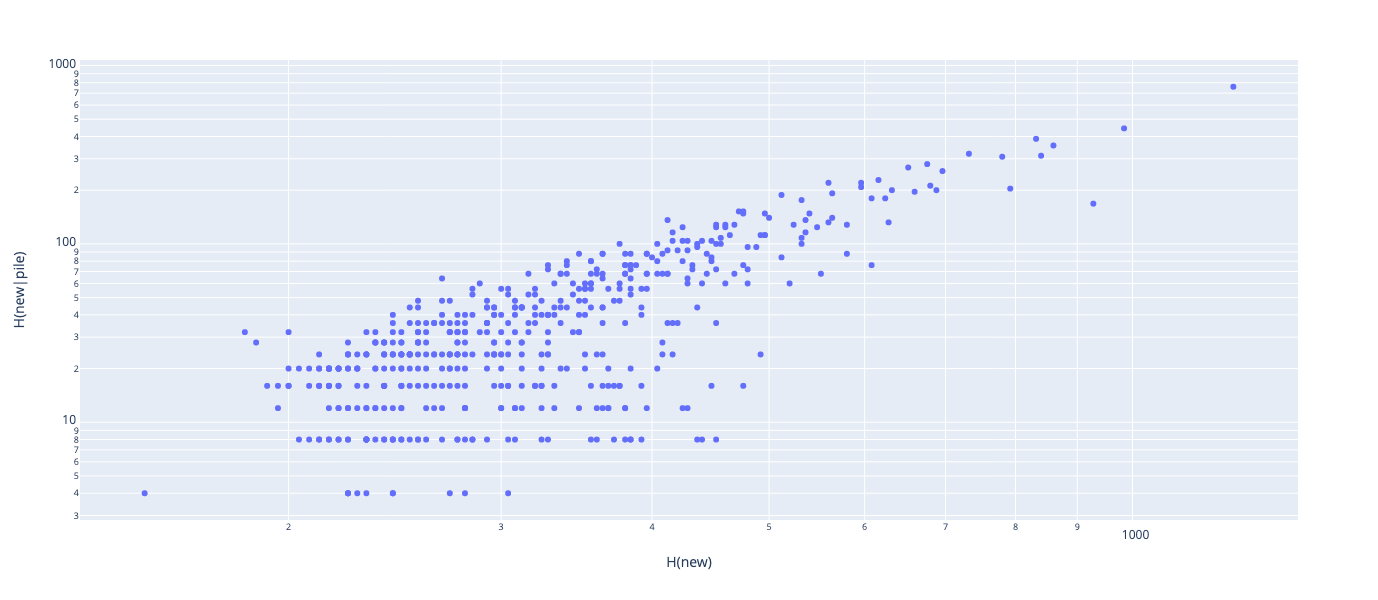

In [491]:
x = []
y = []
for i, (c1,c2,dist,n) in enumerate(linkage):
    x.append(C(*clusters[int(c2)]))
    y.append(C(*(clusters[int(c1)] + clusters[int(c2)])) - C(*clusters[int(c1)]))
import plotly.express as px
px.scatter(x=x, y=y, labels=dict(x="H(new)", y="H(new|pile)"), width=600, height=600, log_x=True, log_y=True)

In [614]:
%%time
clusters = [[s] for s in specs]
remaining = clusters.copy()
linkage = []
while len(remaining) > 1:
    min_dist, c1, c2 = min((  ( 2*C(*(i+j))-C(*i)-C(*j) ), i, j) for i, j in combinations(remaining, 2))
    linkage.append([float(clusters.index(c1)), float(clusters.index(c2)), float(C(*(c1+c2))), float(len(c1+c2))])
    clusters.append(c1+c2)
    remaining.remove(c1)
    remaining.remove(c2)
    remaining.append(c1+c2)


CPU times: user 10.1 s, sys: 16.5 ms, total: 10.1 s
Wall time: 10.1 s


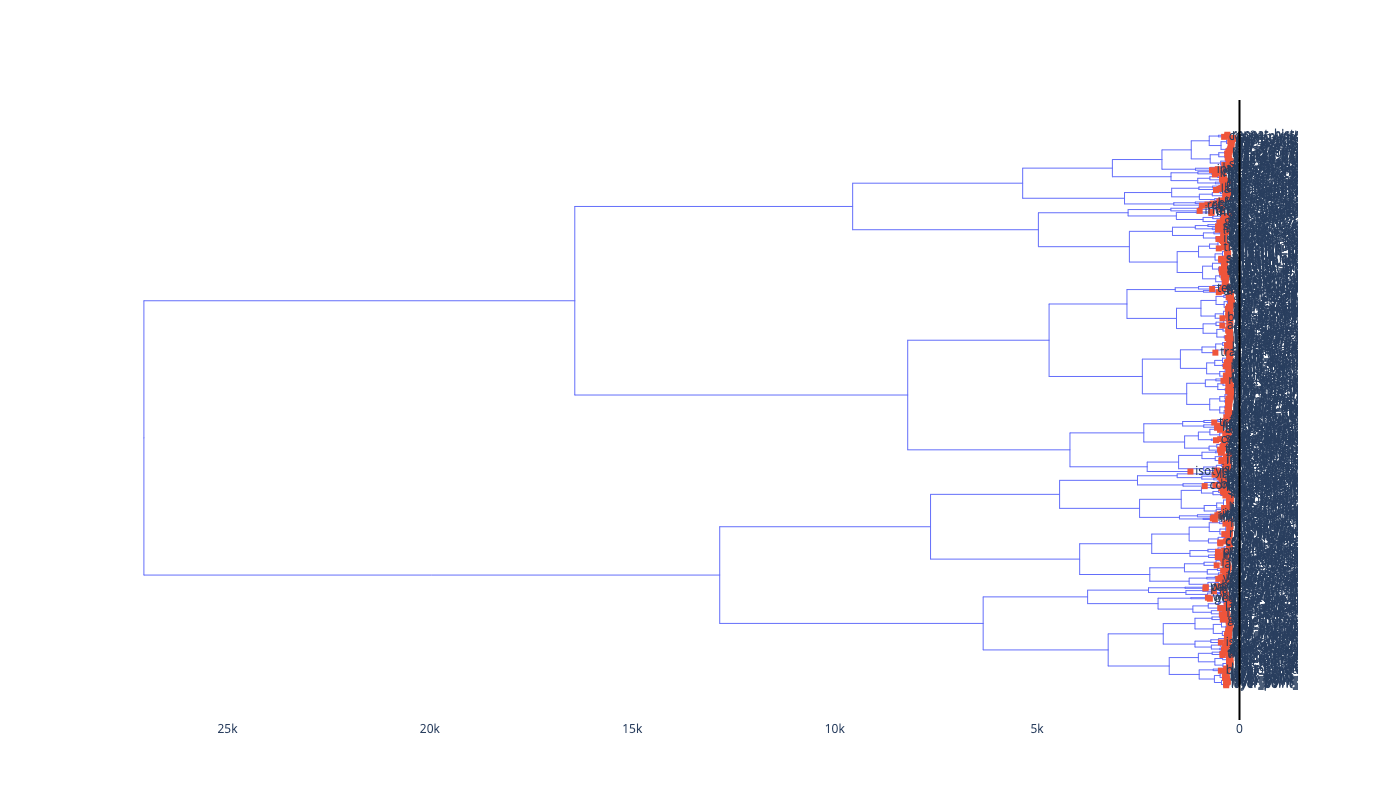

In [615]:
dendro(linkage, specs, True)

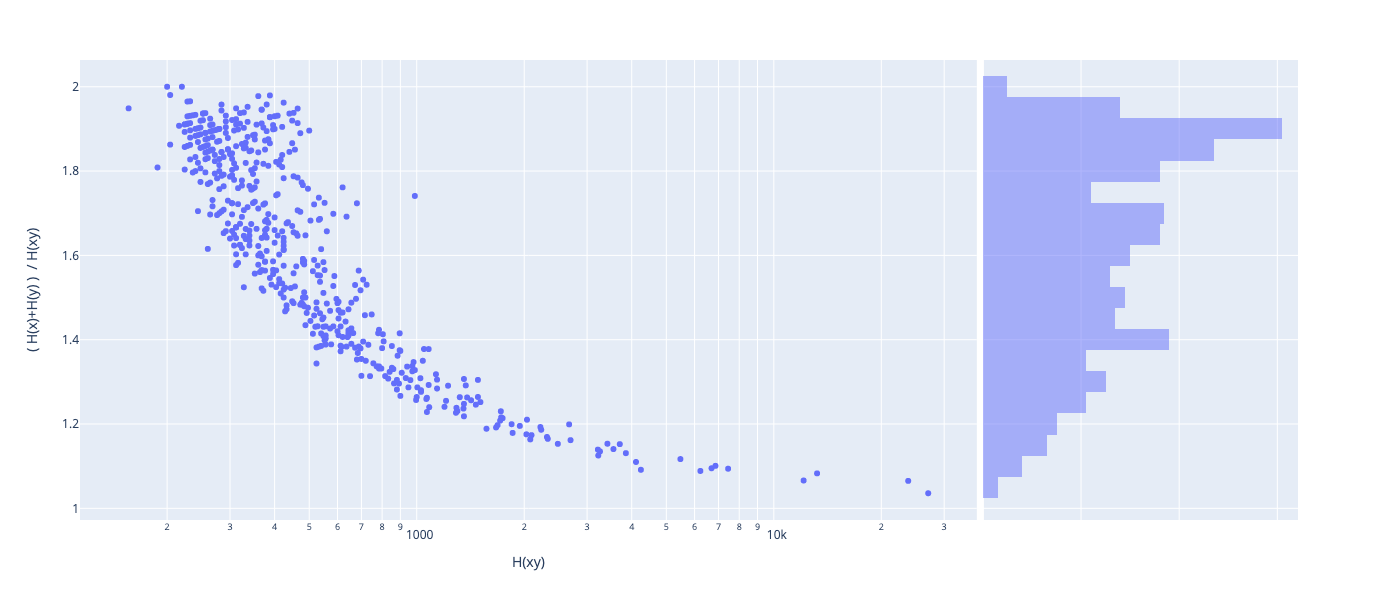

In [605]:
x = []
y = []
for i, (c1,c2,dist,n) in enumerate(linkage):
    y.append(( C(*clusters[int(c2)]) + C(*clusters[int(c1)]) ) / C(*(clusters[int(c1)] + clusters[int(c2)])) )
    x.append( C(*(clusters[int(c1)] + clusters[int(c2)])) )
import plotly.express as px
px.scatter(x=x, y=y, labels=dict(x="H(xy)", y="( H(x)+H(y) )  / H(xy) "), width=600, height=600, log_x=True, marginal_y="histogram")